In [1]:
# hack to make notebook appear full-width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import math
import csv
import pickle
from collections import namedtuple, defaultdict
import time
from glob import glob
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.utils.graph_shortest_path import graph_shortest_path
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Circle, ConnectionPatch

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Create Network Metadata

In [40]:
# Structure for node metadata
NodeMeta = namedtuple("NodeMeta", ["id", "name", "ip", "kind"])
# kind should be one of:
# - Server
# - External
# - Workstation
# - Vulnerable (Vulnerable Workstation)
# - Unknown

# Global list of all nodes
nodes = []

# Function to add a new node to the list
def addnode(ip, name, kind):
    id = len(nodes)
    nodes.append(NodeMeta(id, name, ip, kind))

# firewall, LANs, and servers
addnode("10.200.150.1", "Firewall", kind="Server")
addnode("192.168.1.1", "Vlan10", kind="Server")
addnode("192.168.2.1", "Vlan20", kind="Server")
addnode("172.20.1.1", "DMZ", kind="Server")
addnode("172.20.1.5", "ExtWeb", kind="Server")
addnode("192.168.1.2", "DHCP", kind="Server")
addnode("192.168.1.3", "HR DB", kind="Server")
addnode("192.168.1.4", "Ship DB", kind="Server")
addnode("192.168.1.5", "IntWeb", kind="Server")
addnode("192.168.1.6", "Mail", kind="Server")
addnode("192.168.1.7", "FileServ", kind="Server")
addnode("192.168.1.14", "DNS", kind="Server")
addnode("192.168.1.16", "Snort", kind="Server")
addnode("192.168.1.50", "FWLog", kind="Server")

# unknown (server IP space)
for i in list(range(8,14)) + [15] + list(range(17, 50)) + list(range(51, 256)):
    addnode(f"192.168.1.{i}", f"us{i}", kind="Unknown")

# external machines (public internet)
for i in range(1, 256):
    addnode(f"10.200.150.{i}", f"x{i}", kind="External")

# internal workstations
for i in range(10, 251):
    if 171 <= i <= 175:
        kind = "Vulnerable Workstation"
    else:
        kind = "Workstation"
    addnode(f"192.168.2.{i}", f"w{i}", kind=kind)
    
# unknown (workstation IP space)
for i in range(251, 256):
    addnode(f"192.168.2.{i}", f"uw{i}", kind="Unknown")
    
# lookup table into nodes by IP address
node_by_ip = {node.ip: node for node in nodes}

In [26]:
node_by_ip

{'10.200.150.1': NodeMeta(id=259, name='x1', ip='10.200.150.1', kind='External'),
 '10.200.150.10': NodeMeta(id=268, name='x10', ip='10.200.150.10', kind='External'),
 '10.200.150.100': NodeMeta(id=358, name='x100', ip='10.200.150.100', kind='External'),
 '10.200.150.101': NodeMeta(id=359, name='x101', ip='10.200.150.101', kind='External'),
 '10.200.150.102': NodeMeta(id=360, name='x102', ip='10.200.150.102', kind='External'),
 '10.200.150.103': NodeMeta(id=361, name='x103', ip='10.200.150.103', kind='External'),
 '10.200.150.104': NodeMeta(id=362, name='x104', ip='10.200.150.104', kind='External'),
 '10.200.150.105': NodeMeta(id=363, name='x105', ip='10.200.150.105', kind='External'),
 '10.200.150.106': NodeMeta(id=364, name='x106', ip='10.200.150.106', kind='External'),
 '10.200.150.107': NodeMeta(id=365, name='x107', ip='10.200.150.107', kind='External'),
 '10.200.150.108': NodeMeta(id=366, name='x108', ip='10.200.150.108', kind='External'),
 '10.200.150.109': NodeMeta(id=367, name=

# Indentify firewall files

In [27]:
DATES = ["20110413", "20110414", "20110415"]
FWFILES = [fname
           for date in DATES
           for fname in glob(f"/Users/dbeach/Desktop/MiniChallenge2 Core Data/{date}/firewall/csv/{date}_VAST11MC2_firewall_log*.csv")
]

FWFILES

['/Users/dbeach/Desktop/MiniChallenge2 Core Data/20110413/firewall/csv/20110413_VAST11MC2_firewall_log_1.csv',
 '/Users/dbeach/Desktop/MiniChallenge2 Core Data/20110413/firewall/csv/20110413_VAST11MC2_firewall_log_2.csv',
 '/Users/dbeach/Desktop/MiniChallenge2 Core Data/20110413/firewall/csv/20110413_VAST11MC2_firewall_log_3.csv',
 '/Users/dbeach/Desktop/MiniChallenge2 Core Data/20110413/firewall/csv/20110413_VAST11MC2_firewall_log_4.csv',
 '/Users/dbeach/Desktop/MiniChallenge2 Core Data/20110413/firewall/csv/20110413_VAST11MC2_firewall_log_5.csv',
 '/Users/dbeach/Desktop/MiniChallenge2 Core Data/20110414/firewall/csv/20110414_VAST11MC2_firewall_log.csv',
 '/Users/dbeach/Desktop/MiniChallenge2 Core Data/20110415/firewall/csv/20110415_VAST11MC2_firewall_log.csv']

In [28]:
# Structure for connection events
FWEvent = namedtuple("FWEvent", ["time", "source_ip", "dest_ip", "source_port", "dest_port", "conn_built", "conn_teardown"])

N_FIELDS = 15

(f_time, f_priority, f_operation, f_code, f_protocol, f_source_ip, f_dest_ip, f_source_host, f_dest_host,
 f_source_port, f_dest_port, f_dest_service, f_direction, f_num_conn_built, f_num_conn_teardown) = range(N_FIELDS)

def tryparseint(x, dft=0):
    try:
        return int(x)
    except ValueError:
        return dft

DATE_FORMAT = "%d/%b/%Y %H:%M:%S"
    
def parse_events(fname):
    reader = csv.reader(open(fname))
    header = next(reader) # throw away fields
    assert len(header) == N_FIELDS
    for rec in reader:
        if len(rec) != N_FIELDS:
            print(f"Skipping INVALID LINE: {rec}")
            continue
        t = time.mktime(time.strptime(rec[f_time], DATE_FORMAT))
        source_ip = rec[f_source_ip]
        dest_ip = rec[f_dest_ip]
        if not source_ip or source_ip == "(empty)": continue
        if not dest_ip or dest_ip == "(empty)": continue
        source_port = tryparseint(rec[f_source_port])
        dest_port = tryparseint(rec[f_dest_port])
        conn_built = tryparseint(rec[f_num_conn_built])
        conn_teardown = tryparseint(rec[f_num_conn_teardown])
        yield FWEvent(t, source_ip, dest_ip, source_port, dest_port, conn_built, conn_teardown)
        
def parse_all_events():
    for fname in FWFILES:
        print(f"parsing file: {fname}")
        for event in parse_events(fname):
            yield event    

In [29]:
conn = defaultdict(int)
def add_connection(event):
    num = event.conn_built
    if num == 0: return
    src = node_by_ip[event.source_ip].id
    dest = node_by_ip[event.dest_ip].id
    conn[src, dest] += num
    conn[dest, src] += num

for event in parse_all_events():
    add_connection(event)

# compute weights
weights = defaultdict(int)
for (a, b), num in conn.items():
    weights[a] += num


parsing file: /Users/dbeach/Desktop/MiniChallenge2 Core Data/20110413/firewall/csv/20110413_VAST11MC2_firewall_log_1.csv
parsing file: /Users/dbeach/Desktop/MiniChallenge2 Core Data/20110413/firewall/csv/20110413_VAST11MC2_firewall_log_2.csv
parsing file: /Users/dbeach/Desktop/MiniChallenge2 Core Data/20110413/firewall/csv/20110413_VAST11MC2_firewall_log_3.csv
parsing file: /Users/dbeach/Desktop/MiniChallenge2 Core Data/20110413/firewall/csv/20110413_VAST11MC2_firewall_log_4.csv
parsing file: /Users/dbeach/Desktop/MiniChallenge2 Core Data/20110413/firewall/csv/20110413_VAST11MC2_firewall_log_5.csv
parsing file: /Users/dbeach/Desktop/MiniChallenge2 Core Data/20110414/firewall/csv/20110414_VAST11MC2_firewall_log.csv
Skipping INVALID LINE: []
parsing file: /Users/dbeach/Desktop/MiniChallenge2 Core Data/20110415/firewall/csv/20110415_VAST11MC2_firewall_log.csv
Skipping INVALID LINE: []


In [30]:
pickle.dump({"conn": conn, "weights": weights}, open("connection-summary.pickle", "wb"))

In [9]:
# data = pickle.load(open("connection-summary.pickle", "rb"))
# conn = data["conn"]
# weights = data["weights"]

# Build the Distance Graph

* The connection graph is a graph whose edge weights are labelled with positive values.
* In generaly, the higher the edge weight, the closer the relationship between nodes.
* We need to define distances that we can use in t-SNE.
* We start by defining probabilities between nodes.

Suppose:

- $w_{ij}$ is the edge weights of the connection graph
- $\Sigma w_{i}$ is the sum of all edge weights connecting to node $i$.

Then we can define:

$$p_{j|i} = { w_{ij} \over {\Sigma w_{i}} }$$
  
as the probability that node $i$ will connect to node $j$ assuming it is active.

However, because our graph is symmetric, we need to symmetrize these probabilities, so we define:

$$p_{ij} = { p_{i|j} + p_{j|i} \over 2N }$$
  
Finally, we convert this probability into a distance (cost) by taking the negative log:

$$d_{ij} = - \log p_{ij}$$

The following block of code builds this graph.

In [31]:
xrows = [k[0] for k in conn.keys()]
xcols = [k[1] for k in conn.keys()]

# symmetrized conditional probability:
xvals = [-math.log(0.5 * ((val / weights[i]) + (val / weights[j]))) for (i,j), val in conn.items()]

# joint probabilities assuming independence:
# xvals = [-math.log((val / weights[i]) * (val / weights[j])) for (i,j), val in conn.items()]
# (this does not give good structure in practice)

# create connection graph as a sparse matrix
N = len(nodes)
dist_graph = csr_matrix((xvals, (xrows, xcols)), shape=(N, N))
dist_graph

<760x760 sparse matrix of type '<class 'numpy.float64'>'
	with 1882 stored elements in Compressed Sparse Row format>

## Complete distance function

To complete the distance function, we use Dijkstra's shortet path algorithm to compute the distance between all connected nodes.

Since the edge weights are logs of conditional probabilities, summed paths through the graph can be interpreted as the product of these conditional probabilities.

Note: There may be a better algorithm to use for nodes which are connected by multiple paths, since this would actually make the nodes closer.  However, using the strongest path (with the lowest cost) is a fair approximation for now.

In [32]:
dist_func = graph_shortest_path(dist_graph)
keep_idx = np.nonzero(np.sum(dist_func, 0) > 0)[0]
keep_idx

array([  1,   4,   5,   7,   8,   9,  11,  12,  13,  16,  17,  18,  19,
        20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
        72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
       150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
       163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
       176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 18

In [33]:
used_dist_func = dist_func[keep_idx,:][:,keep_idx]

In [38]:
tsne = TSNE(perplexity=10.0, metric="precomputed", n_iter=1000, learning_rate=50.0)
y = tsne.fit_transform(used_dist_func)

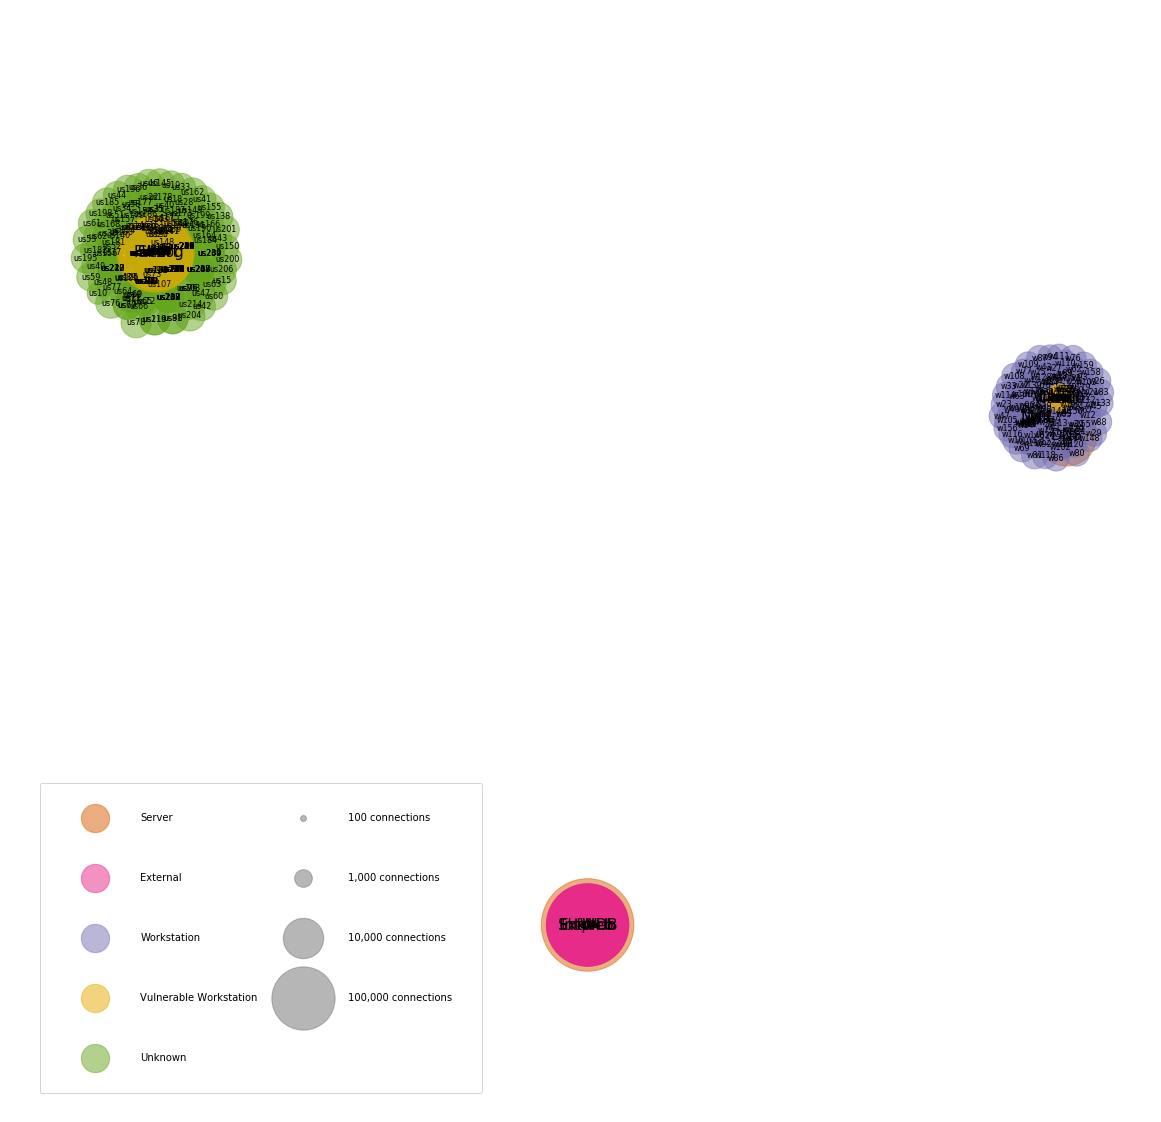

In [39]:
gnodes = [nodes[idx] for idx in keep_idx]
N = len(gnodes)

# Colorbrewer2 Qualitative/Dark/5
# http://colorbrewer2.org/#type=qualitative&scheme=Dark2&n=5
colormap = {
    "Server": "#d95f02",
    "External": "#e7298a",
    "Workstation": "#7570b3",
    "Vulnerable Workstation": "#e6ab02",
    "Unknown": "#66a61e"
}

colors = [colormap[gnodes[i].kind] for i in range(N)]

# This gives sizes that are related to node activity.
# Uses shifted logrithmic scaling to avoid making impossibly small dots.
gweights = [weights[i] for i in keep_idx]
medw = median(gweights)
log2 = math.log(2)
def getsize(w):
    #return 800 * math.log(w) / math.log(medw) # straightforward math, but not enough size variation to be useful
    return 800 * math.log(1 + (w / medw)) / log2 # strange math, but better visual dynamics
    
sizes = [getsize(w) for w in gweights]

fig, ax = plt.subplots(figsize=(20,20))
ax.axis('equal') # graph will appear distorted if axes are not equal
ax.axis('off')   # the numerical values of the axes don't matter, so suppress them

# Add edges.  This adds quite a bit of visual noise.
# dist_keep = dist_graph[keep_idx,:][:,keep_idx]
# for i, j in zip(*dist_keep.nonzero()):
#     val = dist_keep[i,j]
#     if i < j and val > 0:
#         strength = math.exp(-val)
#         patch = ConnectionPatch(y[i], y[j], "data", "data", zorder=0, color="#A0A0A0", alpha=0.5, linewidth=max(0.5, 10*strength))
#         ax.add_patch(patch)

ax.scatter(y[:,0], y[:,1], color=colors, s=sizes, marker='o', alpha=0.5)

for i in range(N):
    node = gnodes[i]
    size = 15 if node.kind == "Server" else 8
    ax.annotate(node.name, xy=y[i], horizontalalignment='center', verticalalignment='center', size=size)
    
# legend
legend_patches = []
# patches for machine types
for (stype, color) in colormap.items():
    patch = ax.scatter([], [], color=color, marker="o", s=getsize(medw), alpha=0.5, label=stype)
    legend_patches.append(patch)
# size scale
for factor in [2,3,4,5]:
    w = 10**factor
    size=getsize(w)
    patch = ax.scatter([], [], color="#707070", marker="o", s=size, alpha=0.5, label="{:,.0f} connections".format(w))
    legend_patches.append(patch)
    
ax.legend(handles=legend_patches, labelspacing=5, handlelength=5, handletextpad=2., borderpad=3, ncol=2, loc=3)



In [15]:
# This is psuedocode-ish

class UpperBound:

    def __init__(self, k):
        self._k = k
        self._q = []

    @property
    def threshold(self):
        return -self._q[0]
        
    def visit(self, value):
        k = self._k
        if len(self._q) == k:
            threshold = -self._q[0]
            if value >= threshold: return
            heappush(q, -value)
            heappop(q)
        else:
            heappush(q, -value)


def graph_nn(start_node):
    """Yield nearest-neighbors from graph in order."""

    pq = []
    for p, d in neighbors(start_node):
        heappush(pq, (d, p))
        
    visited = set([start_node])
    while pq and count < k:
        dist, node = heappop(pq)
        yield (node, dist)
        visited.add(node)
        for p, d in neighbors(node):
            if p not in visited:
                newd = dist + d
                heappush(pq, (newd, p))


def graph_knn(start_node, k):
    pq = []
    for p, d in neighbors(start_node):
        heappush(pq, (d, p))
    
    # by tracking the upper bound, we avoid potentially placing lots of unnecessary items in the priority queue
    visited = set([start_node])
    ub = UpperBound(k)
    while pq and len(visited) < k + 1:
        dist, node = heappop(pq)
        yield (node, dist)
        visited.add(node)
        for p, d in neighbors(node):
            newd = dist + d
            if newd < ub.threshold:
                heappush(pq, (newd, p))
                ub.visit(newd)


In [41]:
math.log(2)

0.6931471805599453

In [42]:
800 / math.log(2)

1154.1560327111708